In [ ]:
!pip install transformers

In [8]:
from transformers import BertModel, BertTokenizer, TrainingArguments, Trainer, BertForSequenceClassification, BertConfig
import json
pretrained_path = "/home/stark/workdir/language_model/hfl-rbt3/"
tokenizer = BertTokenizer.from_pretrained(pretrained_path)
config = BertConfig.from_pretrained(pretrained_path)
data_path = "../../../../../DataCLUE/datasets/iflytek"
def get_iflytek_label(filepath):
  id2label = dict()
  with open(filepath, "r", encoding="utf-8") as f:
    for line in f:
      label_json = json.loads(line)
      id2label[label_json["label"]] = label_json["label"]
config.num_labels = 119
model = BertForSequenceClassification.from_pretrained(pretrained_path, config=config)

Some weights of the model checkpoint at /home/stark/workdir/language_model/hfl-rbt3/ were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized f

In [3]:
model.train()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [4]:
import torch
import os
import json
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import numpy as np
import pylab as pl

class StsbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

def get_dataset(datapath, tokenizer, max_length):
    train_data = []
    with open(os.path.join(datapath, "train.json"), "r", encoding="utf-8") as f:
        for idx, line in enumerate(f):
            sample = json.loads(line.strip())
            sentence = sample["sentence"]
            label = sample["label"]
            train_data.append((sentence, label))
    train_data = train_data
    dev_data = []
    with open(os.path.join(datapath, "dev.json"), "r", encoding="utf-8") as f:
        for idx, line in enumerate(f):
            sample = json.loads(line.strip())
            sentence = sample["sentence"]
            label = sample["label"]
            dev_data.append((sentence, label))
    train_texts = [t[0] for t in train_data]
    train_labels = [int(t[1]) for t in train_data]
    dev_texts = [t[0] for t in dev_data]
    dev_labels = [int(t[1]) for t in dev_data]
    train_encodings = tokenizer(train_texts, max_length=max_length, truncation=True, padding='max_length', return_tensors="pt")
    dev_encodings = tokenizer(dev_texts, max_length=max_length, truncation=True, padding='max_length', return_tensors="pt")
    train_dataset = StsbDataset(train_encodings, train_labels)
    dev_dataset = StsbDataset(dev_encodings, dev_labels)
    return train_dataset, dev_dataset

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(np.array(labels), np.array(preds))
    cm = confusion_matrix(np.array(labels), np.array(preds))
    pl.matshow(cm)
    pl.title('Confusion matrix of the classifier')
    pl.colorbar()
    pl.show()
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [9]:
from transformers import Trainer, TrainingArguments
train_dataset, dev_dataset = get_dataset(data_path, tokenizer, max_length=256)

In [10]:
from torch.utils.data import DataLoader
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=True)
training_args = TrainingArguments(
    output_dir="./output",      
    overwrite_output_dir=True,    # output directory
    num_train_epochs=6,       # total number of training epochs
    per_device_train_batch_size=64, # batch size per device during training
    per_device_eval_batch_size=64,  # batch size for evaluation
    warmup_steps=50,        # number of warmup steps for learning rate scheduler
    weight_decay=0.01,        # strength of weight decay
    logging_dir="./log",       # directory for storing logs
    logging_steps=10,
    do_eval=True,
    evaluation_strategy='epoch',
    learning_rate=2e-5, 
    adam_beta1=0.9, 
    adam_beta2=0.999, 
    tpu_num_cores=1,
    save_steps=100)

***** Running training *****
  Num examples = 12133
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 475
/home/stark/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/stark/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/stark/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as

/home/stark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/stark/anaconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.784200,3.605536,0.233167,0.012485,0.022750,0.022967
2,2.932400,2.820428,0.400923,0.084159,0.117471,0.096405
3,2.466000,2.497900,0.474798,0.132322,0.150864,0.146201
4,2.234400,2.356944,0.504810,0.167671,0.192305,0.180639
5,2.320000,2.320898,0.514429,0.177791,0.197783,0.191295


***** Running Evaluation *****
  Num examples = 2599
  Batch size = 256
/home/stark/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


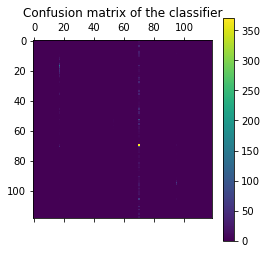

/home/stark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/stark/anaconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Saving model checkpoint to ./output/checkpoint-100
Configuration saved in ./output/checkpoint-100/config.json
Model weights saved in ./output/checkpoint-100/pytorch_model.bin
/home/stark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

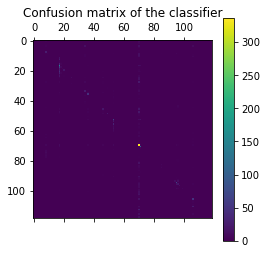

/home/stark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/stark/anaconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Saving model checkpoint to ./output/checkpoint-200
Configuration saved in ./output/checkpoint-200/config.json
Model weights saved in ./output/checkpoint-200/pytorch_model.bin
/home/stark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

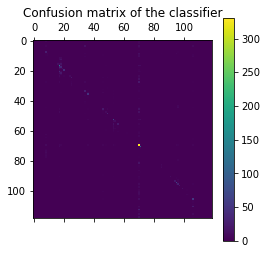

/home/stark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/stark/anaconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Saving model checkpoint to ./output/checkpoint-300
Configuration saved in ./output/checkpoint-300/config.json
Model weights saved in ./output/checkpoint-300/pytorch_model.bin
/home/stark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

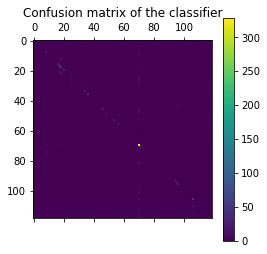

/home/stark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/stark/anaconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Saving model checkpoint to ./output/checkpoint-400
Configuration saved in ./output/checkpoint-400/config.json
Model weights saved in ./output/checkpoint-400/pytorch_model.bin
/home/stark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

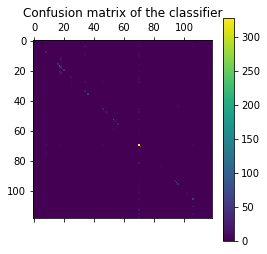



Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=475, training_loss=2.9626833825362358, metrics={'train_runtime': 162.536, 'train_samples_per_second': 373.24, 'train_steps_per_second': 2.922, 'total_flos': 2045076824947200.0, 'train_loss': 2.9626833825362358, 'epoch': 5.0})

In [11]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics             # evaluation dataset
)

trainer.train()